# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "E:/AV/DataSetExploration/drone-dataset-tools/data/location-2/home"

dataDir = "/home/office/AV/DataSetExploration/data/ind/location-2/csv"

In [2]:
exec(open('init_notebook.py').read())

current working dir/home/office/AV/DataSetExploration/TTI-dataset-tools/src


In [3]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper
from ind_tools.IndTransformer import IndTransformer
from tti_dataset_tools import CrosswalkModel

In [13]:

date = "2022-12-22"
fps=5
maxXDisplacement = 9

sceneDisplacementMap = {
    21: 8,
    22: 8,
    31: 5
}

sceneRoadWidth = {
    21: 9,
    22: 9,
    31: 6,
    11: 6
}

    

In [14]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed'
    )
transformer = TrajectoryTransformer(colMapper)
indTransformer = IndTransformer(colMapper)
crosswalkModel = CrosswalkModel(colMapper)

Processing scene #21
using min Y displacement (8)


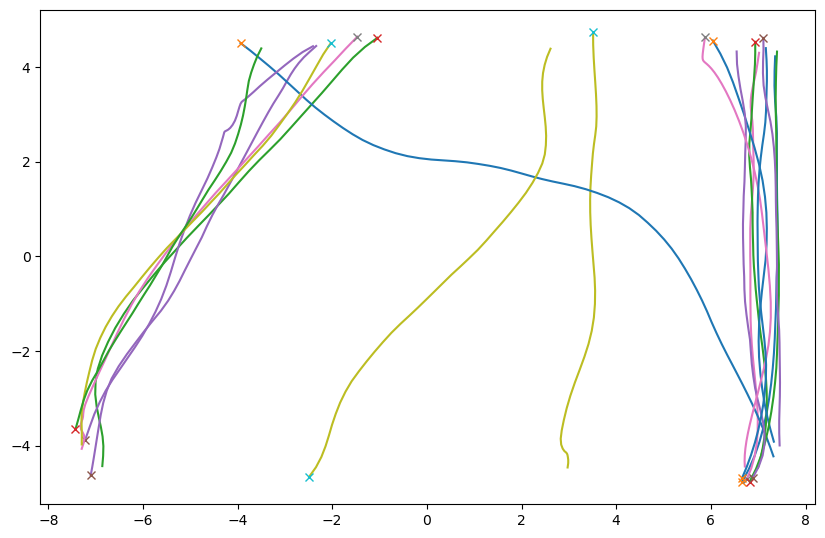

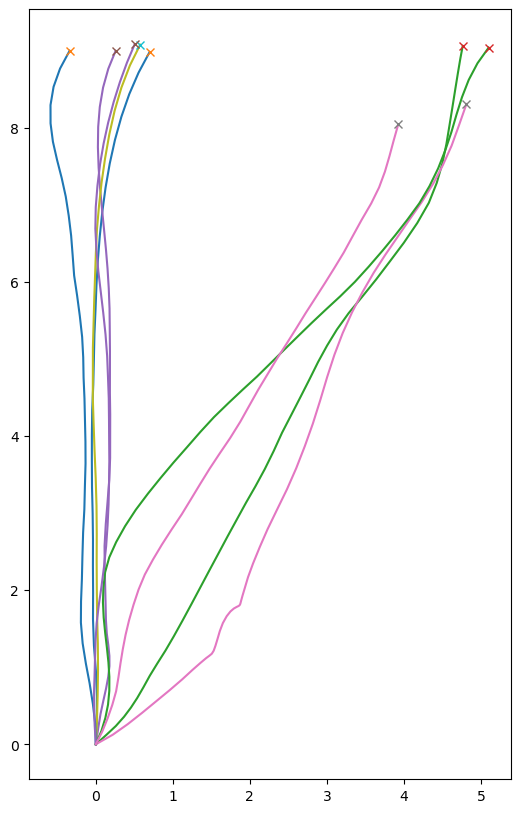

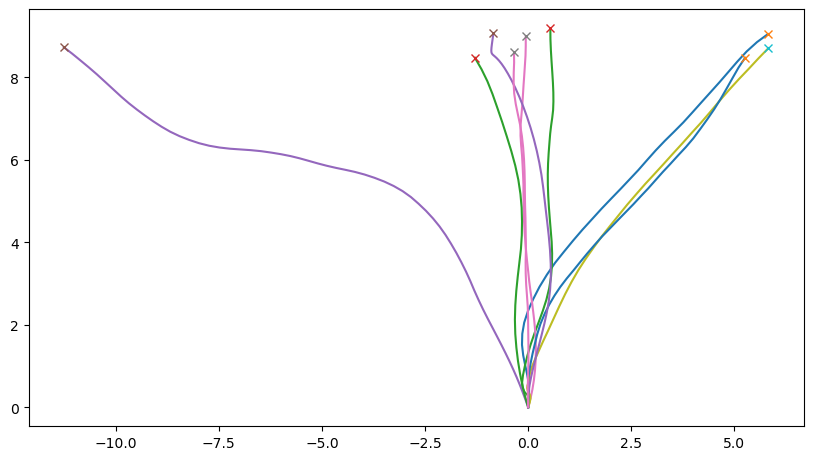

Processing scene #22
using min Y displacement (8)


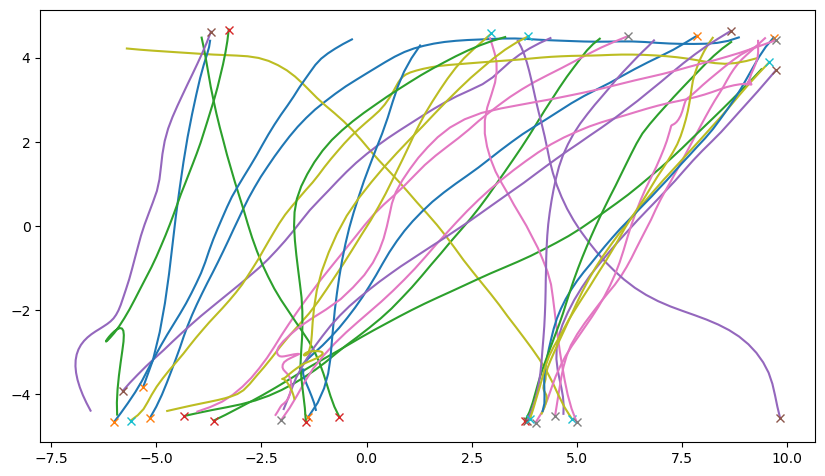

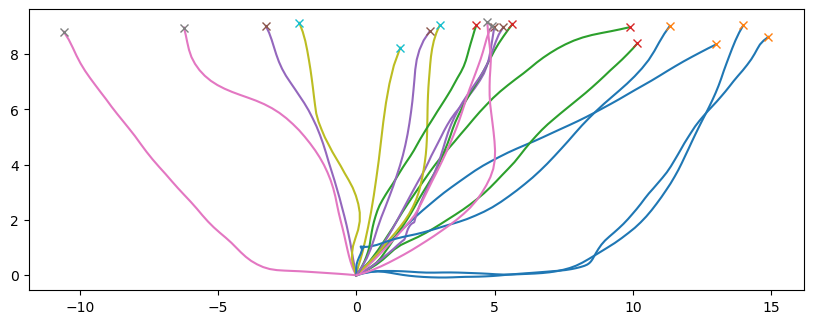

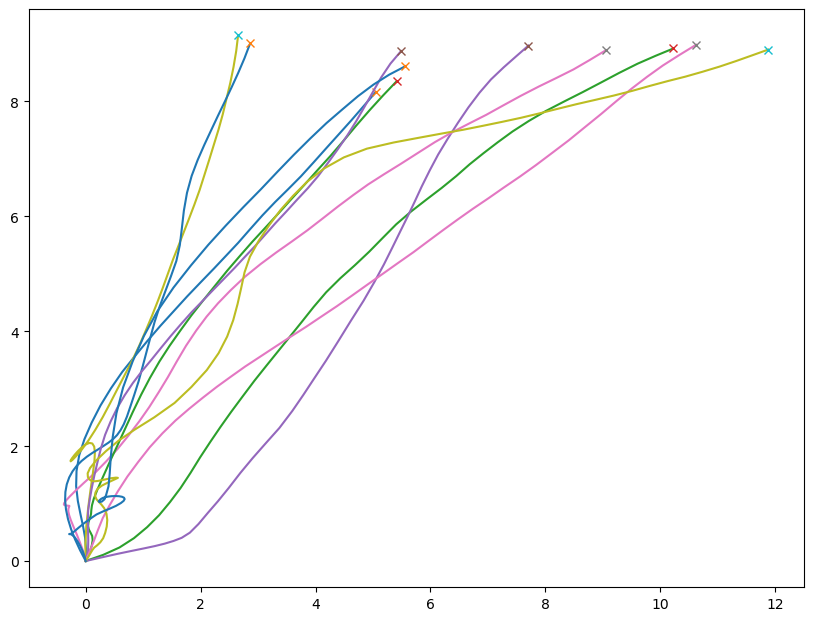

Processing scene #31
using min Y displacement (5)


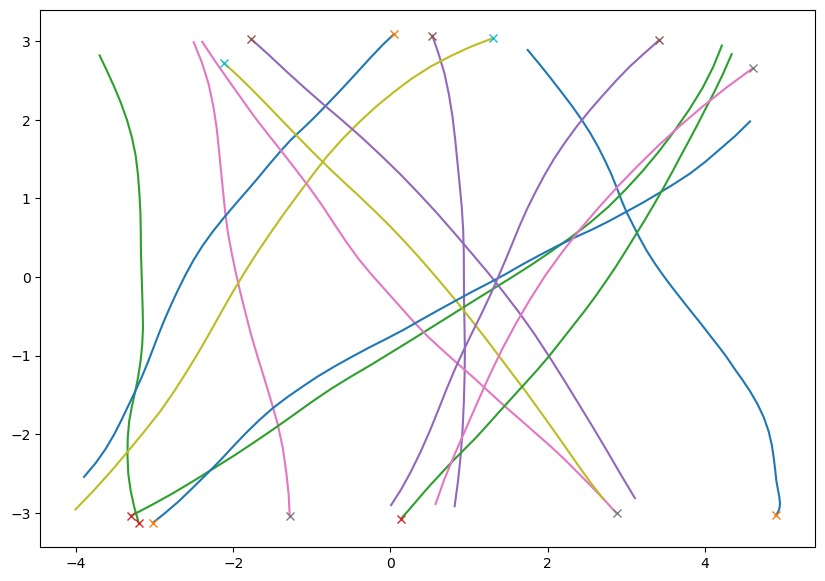

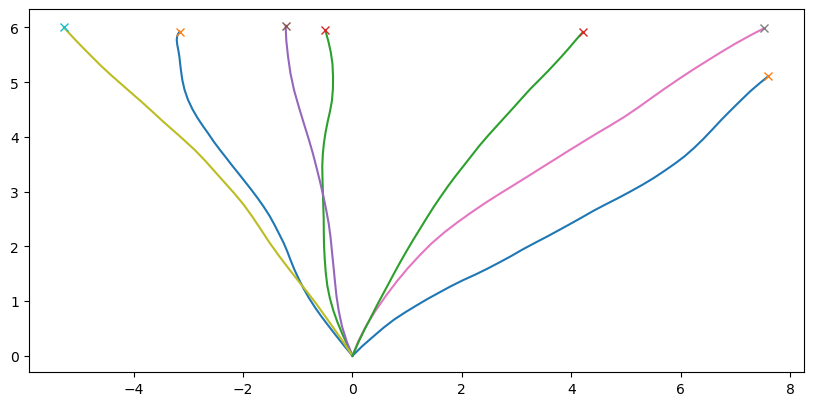

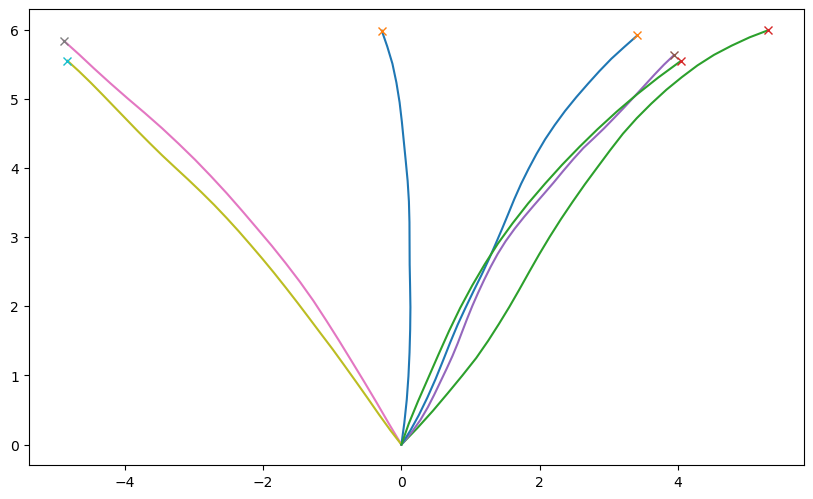

In [15]:
sceneData = {}
for sceneId in sceneDisplacementMap:
    print(f"Processing scene #{sceneId}")
    cleaner = TrajectoryCleaner(
        colMapper = colMapper,
        minSpeed = 0.0,
        maxSpeed = 3.5,
        minYDisplacement = sceneDisplacementMap[sceneId],
        maxXDisplacement = maxXDisplacement
    )
    pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
    otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
    tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))
    transformer.deriveSpeed(pedDf)
    transformer.deriveDisplacements(pedDf)
    
    cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
    visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
    
    allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
    transformer.translateAllToLocalSource(cleanPedDf)
    
    southIds = indTransformer.convertLocalToNorth(cleanPedDf, tracksMeta)
    # visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
    southPeds = cleanPedDf[cleanPedDf["uniqueTrackId"].isin(southIds)]
    visualizer.show(southPeds, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
    northPeds = cleanPedDf[~cleanPedDf["uniqueTrackId"].isin(southIds)]
    visualizer.show(northPeds, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
    
    roadWidth = sceneRoadWidth[sceneId]
    interval = 1.0
    yTolerance = 0.1

    yBreakpoints = [1, roadWidth - 1, roadWidth] # start, mid, end

    breakpointXVals = crosswalkModel.getAllLocalXAtLocalYBreakpoints(
            tracksDf = southPeds,
            yBreakpoints = yBreakpoints,
            yTolerance = yTolerance
        )
    
    minVals = [min(breakpointXVals[y]) for y in yBreakpoints]
    maxVals = [max(breakpointXVals[y]) for y in yBreakpoints]
    
    sceneData[sceneId] = {
        "pedDf": pedDf,
        "otherDf": otherDf,
        "meta": tracksMeta,
        "minVals": minVals,
        "maxVals": maxVals
    }


In [ ]:
for sceneId in sceneData:
    print(